In [1]:
import torch
import pickle
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from tabpfn import TabPFNClassifier  
from functools import partial
import tabpfn.encoders as encoders
from tabpfn.scripts.transformer_prediction_interface import transformer_predict, get_params_from_config, load_model_workflow_my
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
'''
# 加载数据
train = pd.read_csv('/root/autodl-fs/data/train_revise+45缩减到100特征 数量1000个 去掉三列和Name.csv')  

# 分离特征和标签
X = train.drop(['senolytic'], axis=1).values  # 转为 NumPy 数组
y = train['senolytic'].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 转为 PyTorch 张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).cuda()
y_train_tensor = torch.tensor(y_train, dtype=torch.long).cuda()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).cuda()
y_test_tensor = torch.tensor(y_test, dtype=torch.long).cuda()

# 构造 DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
'''

"\n# 加载数据\ntrain = pd.read_csv('/root/autodl-fs/data/train_revise+45缩减到100特征 数量1000个 去掉三列和Name.csv')  \n\n# 分离特征和标签\nX = train.drop(['senolytic'], axis=1).values  # 转为 NumPy 数组\ny = train['senolytic'].values\n\n# 划分训练集和测试集\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# 转为 PyTorch 张量\nX_train_tensor = torch.tensor(X_train, dtype=torch.float32).cuda()\ny_train_tensor = torch.tensor(y_train, dtype=torch.long).cuda()\n\nX_test_tensor = torch.tensor(X_test, dtype=torch.float32).cuda()\ny_test_tensor = torch.tensor(y_test, dtype=torch.long).cuda()\n\n# 构造 DataLoader\ntrain_dataset = TensorDataset(X_train_tensor, y_train_tensor)\ntest_dataset = TensorDataset(X_test_tensor, y_test_tensor)\n\ntrain_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)\ntest_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)\n"

In [3]:
# 加载数据
train = pd.read_csv('/root/autodl-fs/data/train_revise+45缩减到100特征 数量1000个 去掉三列和Name.csv')  

# 分离特征和标签
X = train.drop(['senolytic'], axis=1).values
y = train['senolytic'].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用 SMOTE 对训练集进行过采样
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# 转为 PyTorch 张量
X_train_tensor = torch.tensor(X_train_balanced, dtype=torch.float32).cuda()
y_train_tensor = torch.tensor(y_train_balanced, dtype=torch.long).cuda()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).cuda()
y_test_tensor = torch.tensor(y_test, dtype=torch.long).cuda()

# 构造 DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
#print(type(sampled_datasets[0]))
#print(sampled_datasets[0])

In [5]:
# 定义模型
model = TabPFNClassifier(device='cuda', model_file="/root/autodl-fs/Sq-TabPFN/tabpfn/smote+sq_models_diff/prior_diff_real_checkpoint_n_1_epoch_110.cpkt")
#print(model.model)

Loading /root/autodl-fs/Sq-TabPFN/tabpfn/smote+sq_models_diff/prior_diff_real_checkpoint_n_1_epoch_110.cpkt
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [6]:
transformer_model = model.model[2] 

In [7]:
# 冻结 TransformerModel 的编码器部分
for name, param in transformer_model.named_parameters():
    if any(key in name for key in ['encoder', 'transformer_encoder', 'y_encoder']):
        param.requires_grad = False

# 检查冻结情况
#for name, param in transformer_model.named_parameters():
#    print(f"{name}: {'Frozen' if not param.requires_grad else 'Trainable'}")

In [8]:
# 优化器仅包含解码器的参数
#optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, transformer_model.parameters()), lr=1e-4)


# 初始化优化器和学习率调度器
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, transformer_model.parameters()), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6, verbose=True)


In [9]:
for batch in train_loader:
    #print(f"Batch: {batch}")  # 打印 batch 内容
    break

In [10]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        """
        Initializes the early stopping mechanism.
        :param patience: Number of epochs with no improvement after which training will stop.
        :param delta: Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [13]:
# Early stopping 初始化
early_stopping = EarlyStopping(patience=5, delta=0.001)

num_epochs = 50  # 设置最大训练轮数
single_eval_pos = 0  # 设置 single_eval_pos 的值

best_val_loss = float('inf')  # 用于记录最佳验证损失
best_model_path = ""  # 用于记录最佳模型保存路径

for epoch in range(num_epochs):
    transformer_model.train()  # 设置模型为训练模式

    # 训练阶段
    total_loss = 0.0
    for batch in train_loader:
        x, y = batch
        y = y.float()  # 转换标签为 Float 类型
        
        src = (x, y)
        outputs = transformer_model(src, single_eval_pos=single_eval_pos)
        
        # 计算损失
        loss = transformer_model.criterion(outputs, y.long())
        loss = loss.mean()  # 确保损失为标量
        
        # 优化步骤
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)

    # 验证阶段
    transformer_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            y = y.float()  # 转换标签为 Float 类型
            
            src = (x, y)
            outputs = transformer_model(src, single_eval_pos=single_eval_pos)
            loss = transformer_model.criterion(outputs, y.long())
            val_loss += loss.mean().item()
    
    val_loss /= len(test_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    # 动态调整学习率
    scheduler.step(val_loss)
    
    # 检查是否为当前最小验证损失
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_path = f"/root/autodl-fs/Sq-TabPFN/tabpfn/增强微调模型/微调解码器模型/prior_diff_real_checkpoint_n_1_epoch_{epoch+1}.cpkt"
        best_model_path = save_path  # 更新最佳模型路径
        torch.save({
            'model_state_dict': transformer_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            # 'config_sample': config_sample  # 如果有配置文件也可以保存
        }, save_path)
        print(f"New best model saved at epoch {epoch+1} to {save_path}")
        
    # 检查早停条件
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

print(f"Training completed. Best validation loss: {best_val_loss:.4f}")
print(f"Best model saved at: {best_model_path}")

Epoch 1/50, Train Loss: 0.6367, Validation Loss: 0.6299
New best model saved at epoch 1 to /root/autodl-fs/Sq-TabPFN/tabpfn/增强微调模型/微调解码器模型/prior_diff_real_checkpoint_n_1_epoch_1.cpkt
Epoch 2/50, Train Loss: 0.6374, Validation Loss: 0.6427
Epoch 3/50, Train Loss: 0.6440, Validation Loss: 0.6315
Epoch 00023: reducing learning rate of group 0 to 6.2500e-06.
Epoch 4/50, Train Loss: 0.6385, Validation Loss: 0.6467
Epoch 5/50, Train Loss: 0.6381, Validation Loss: 0.6506
Epoch 6/50, Train Loss: 0.6341, Validation Loss: 0.6419
Early stopping at epoch 6
Training completed. Best validation loss: 0.6299
Best model saved at: /root/autodl-fs/Sq-TabPFN/tabpfn/增强微调模型/微调解码器模型/prior_diff_real_checkpoint_n_1_epoch_1.cpkt


In [14]:
# 模型验证和指标计算
def evaluate_model(model, test_loader):
    model.eval()  # 切换到评估模式
    y_true = []
    y_pred = []
    y_prob = []  # 用于 ROC 和 PR 曲线

    with torch.no_grad():  # 禁用梯度计算
        for batch in test_loader:
            x, y = batch
            src = (x, y.float())  # 构造符合模型输入格式的元组
            outputs = model(src, single_eval_pos=0)
            
            # 获取预测类别和概率
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_prob.extend(outputs[:, 1].cpu().numpy())  # 假设二分类，取概率值

    # 转换为 NumPy 数组
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    # 计算指标
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_vals, precision_vals)

    # 打印指标
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")

    return y_true, y_pred, y_prob, precision_vals, recall_vals, roc_auc, pr_auc

# 评估模型性能
y_true, y_pred, y_prob, precision_vals, recall_vals, roc_auc, pr_auc = evaluate_model(transformer_model, test_loader)


Accuracy: 0.6100
Precision: 0.2289
Recall: 0.5758
F1 Score: 0.3276
ROC AUC: 0.6605
PR AUC: 0.2856


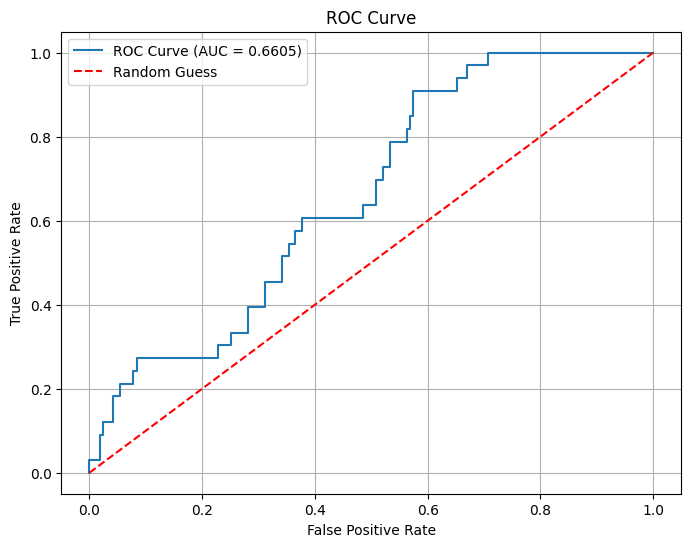

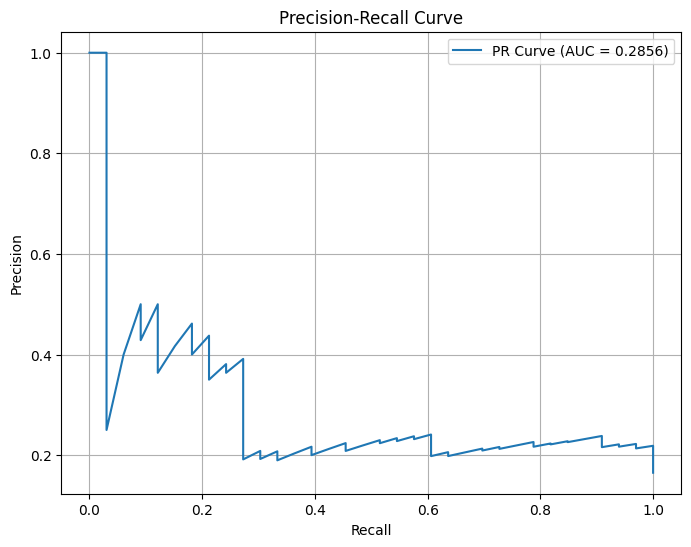

In [15]:
# 绘制 ROC 曲线
def plot_roc_curve(y_true, y_prob, roc_auc):
    from sklearn.metrics import roc_curve

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'r--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

# 绘制 PR 曲线
def plot_pr_curve(precision_vals, recall_vals, pr_auc):
    plt.figure(figsize=(8, 6))
    plt.plot(recall_vals, precision_vals, label=f"PR Curve (AUC = {pr_auc:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

# 绘制曲线
plot_roc_curve(y_true, y_prob, roc_auc)
plot_pr_curve(precision_vals, recall_vals, pr_auc)